In [1]:
%pylab inline
%config InlineBackend.figure_format='retina'
import seaborn
import networkx
from grave import grave
from SuchTree import SuchTree, SuchLinkedTrees
import pandas
import cartopy.crs
from cartopy.io.img_tiles import OSM
#from geopy.geocoders import Nominatim
#from geopy.distance import geodesic
from scipy.cluster import hierarchy
import screed
#import os
import pyprind

Populating the interactive namespace from numpy and matplotlib


In [2]:
metadata = pandas.read_csv( 'data/Table1_5_combined.txt', sep='\t', 
                      dtype={'Body_site':str, 'POGs_SUBFAMILY':str} )
metadata.head()

,UViG,TAXON_OID,Scaffold_ID,VIRAL_CLUSTERS,Ecosystem,Ecosystem_Category,Ecosystem_Type,Ecosystem_Subtype,Habitat,Body_site,...,Host,Host_detection,Host_domain,Estimated_completeness,Quality,POGs_ORDER,POGs_FAMILY,POGs_SUBFAMILY,POGs_GENUS,putative_retrovirus
0,2003000007_____2003296998,2003000007,2003296998,sg_24096,Environmental,Air,Outdoor Air,0,Air,NaN,...,NaN,NaN,Bacteria,NaN,Genome_fragment,NaN,NaN,NaN,NaN,NaN
1,2003000007_____2003297061,2003000007,2003297061,sg_24097,Environmental,Air,Outdoor Air,0,Air,NaN,...,NaN,NaN,Bacteria,NaN,Genome_fragment,NaN,NaN,NaN,NaN,NaN
2,2003000007_____2003297087,2003000007,2003297087,sg_24098,Environmental,Air,Outdoor Air,0,Air,NaN,...,NaN,NaN,Bacteria,NaN,Genome_fragment,NaN,NaN,NaN,NaN,NaN
3,2003000007_____2003297164,2003000007,2003297164,sg_24099,Environmental,Air,Outdoor Air,0,Air,NaN,...,NaN,NaN,Bacteria,NaN,Genome_fragment,NaN,NaN,NaN,NaN,NaN
4,2003000007_____2003297262,2003000007,2003297262,sg_24100,Environmental,Air,Outdoor Air,0,Air,NaN,...,NaN,NaN,NaN,NaN,Genome_fragment,NaN,NaN,NaN,NaN,NaN


In [3]:
lastal_cols = [ 'query_id', 'subject_id', 'identity', 'alignment_length',
                'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start',
                's_end', 'evalue', 'bitscore', 'query_length', 'subject_length',
                'raw_score' ]

isomags = pandas.read_csv( 'data/spacers_vs_all_viral_sequences_combined_v2_Filtered_1Snp_100AF.lout', 
                      sep='\t', names=lastal_cols, index_col=False )

isomags.head()

,query_id,subject_id,identity,alignment_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue,bitscore,query_length,subject_length,raw_score
0,637000024:NC_003228:2:2998261,7000000526_____SRS019397_WUGC_scaffold_4145,100.00,34,0,0,34,1,22441,22474,1.400000e-08,55.3,34,47940,34
1,637000024:NC_003228:2:2998455,7000000526_____SRS019397_WUGC_scaffold_4145,97.06,34,1,0,1,34,22655,22688,2.500000e-07,52.2,34,47940,32
2,637000024:NC_003228:3:4661323,3300007975_____Ga0114169_100414,96.67,30,1,0,30,1,1397,1426,3.200000e-05,45.9,30,20299,28
3,637000024:NC_003228:3:4661323,7000000131_____C1053521,96.67,30,1,0,1,30,29086,29115,3.200000e-05,45.9,30,30419,28
4,637000024:NC_003228:3:4661400,3300006487_____Ga0100256_10099,100.00,30,0,0,30,1,44872,44901,1.800000e-06,49.0,30,60085,30


In [4]:
metaspacers = pandas.read_csv( 'data/imgvr/meta_spacers_vs_imgvr_filtered.lout',
                               sep='\t', names=lastal_cols[:-1], index_col=False, skiprows=1 )

metaspacers.head()

,query_id,subject_id,identity,alignment_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue,bitscore,query_length,subject_length
0,2001200001:2001262804:1:1120,3300006255_____Ga0099353_1000130,96.77,31,1,0,1,31,6138,6108,0.000005,54.6,31,36935
1,2001200001:2001262804:1:1120,3300006255_____Ga0099353_1000130,96.77,31,1,0,1,31,6140,6110,0.000005,54.6,31,36935
2,2001200001:2001262804:1:1120,3300006255_____Ga0099353_1000130,96.77,31,1,0,31,1,6108,6138,0.000005,54.6,31,36935
3,2001200001:2001262804:1:1120,3300006255_____Ga0099353_1000130,96.77,31,1,0,31,1,6110,6140,0.000005,54.6,31,36935
4,2001200001:2001262804:1:1120,3300009687_____Ga0116144_10001991,96.77,31,1,0,1,31,22932,22962,0.000005,54.6,31,23036


In [5]:
from Bio import SeqIO
import gzip

isomagspacer_records = [ r.id for r in SeqIO.parse( open( 'data/viral_spacers.fna' ), 'fasta' ) ]
metaspacer_records   = [ r.id for r in SeqIO.parse( gzip.open( 'data/meta_spacers.fna.gz', 'rt' ), 'fasta' ) ]

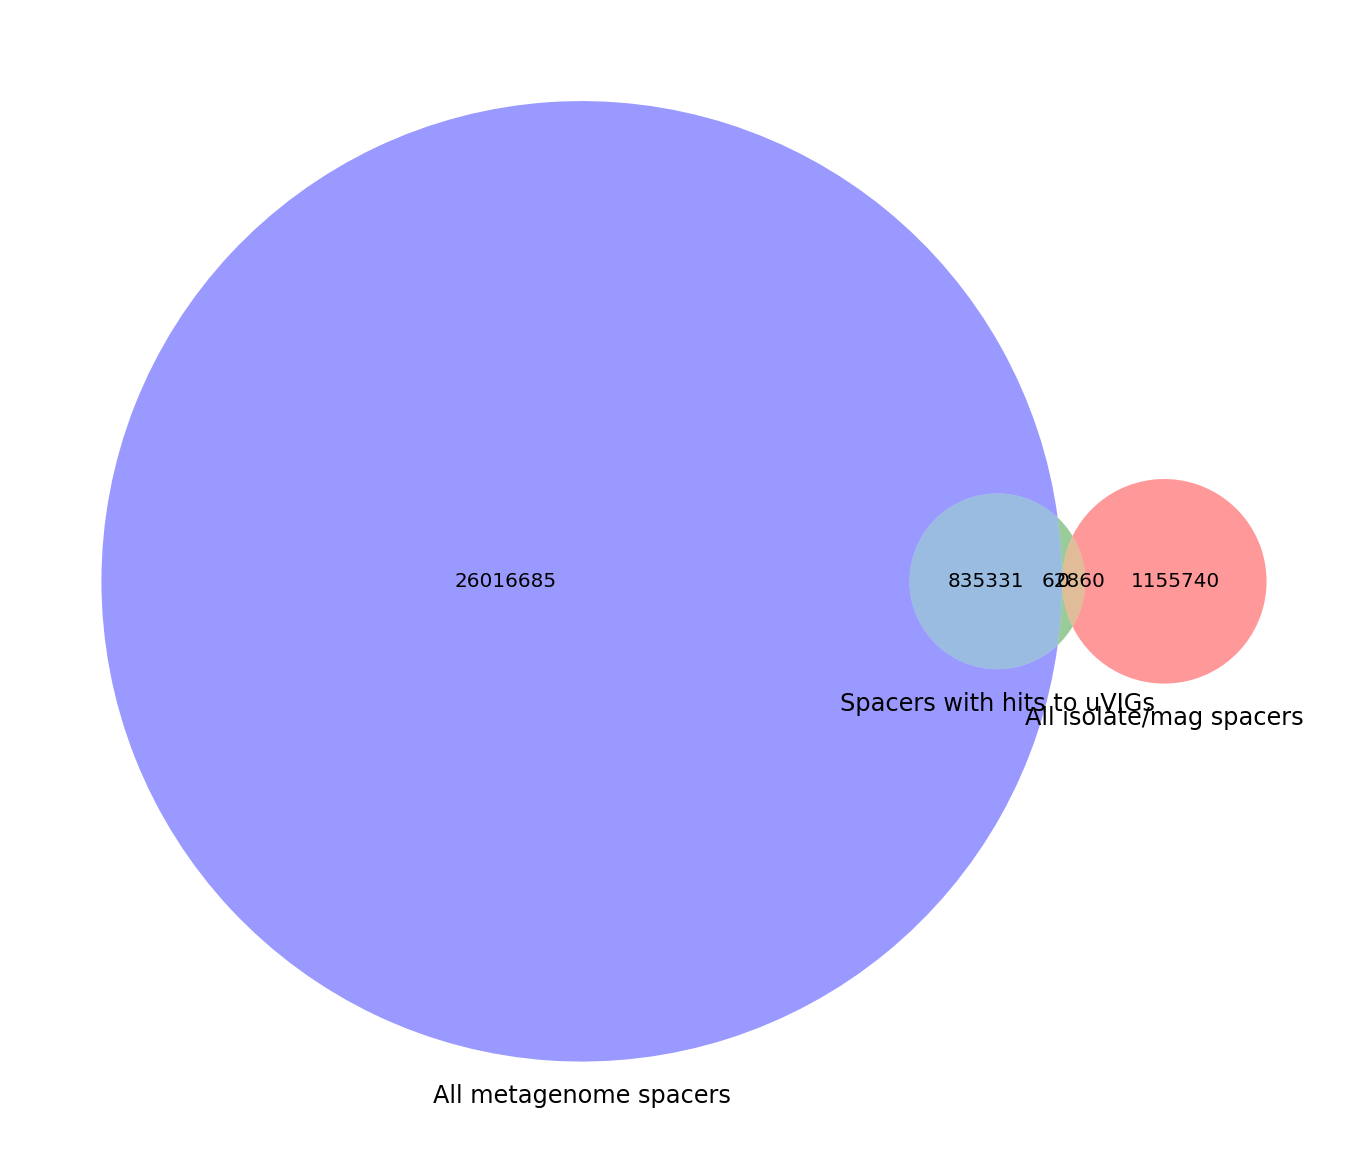

In [9]:
from matplotlib_venn import venn2, venn3

figure( figsize=(12,12) )

venn3( [ set(isomagspacer_records),
         set(isomags.query_id) | set(metaspacers.query_id),
         set(metaspacer_records) ],
       set_labels=[ 'All isolate/mag spacers',
                    'Spacers with hits to uVIGs',
                    'All metagenome spacers' ] )

In [6]:
isomags['source'] = 'isomag'
metaspacers['source'] = 'metagenome'

allspacers = isomags.append(metaspacers)
print( 'isolats + MAGs :', isomags.shape[0] )
print( 'metaspacers    :', metaspacers.shape[0] )
print( 'all hits       :', allspacers.shape[0] )

isolats + MAGs : 269944
metaspacers    : 5760396
all hits       : 6030340


In [7]:
v2h_taxonomy = pandas.read_csv( 'data/predicted_hosts.tsv', sep='\t' )

# merge viral clusters
clusters = metadata[ ['UViG', 'VIRAL_CLUSTERS'] ]
clusters.columns = [ 'subject_id', 'vcluster' ]
allspacers = allspacers.merge( clusters, on='subject_id' )

# merge CRISPR array
allspacers['CRISPR_array'] = [ ':'.join(name.split(':')[:2]) for name in allspacers.query_id ]

allspacers['host_img_oid'] = [ int(i.split(':')[0]) for i in allspacers['CRISPR_array'] ]

allspacers = allspacers.merge( v2h_taxonomy, left_on='host_img_oid', right_on='Host_Taxon_ID' )

print(allspacers.shape)
allspacers.head()

(10539190, 41)


,alignment_length,bitscore,evalue,gap_opens,identity,mismatches,q_end,q_start,query_id,query_length,...,Spacer_stop,Host_genome_type,Host_Domain,Host_Phylum,Host_Class,Host_Order,Host_Family,Host_Genus,Host_Species,SPACER_SEQ
0,34,55.3,1.400000e-08,0,100.0,0,1,34,637000024:NC_003228:2:2998261,34,...,22474,Bacteroides fragilis NCTC 9343,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides fragilis,AGCAAGGGAAACTGTACGATGTACAAGTACTCGG
1,34,55.3,1.400000e-08,0,100.0,0,1,34,637000024:NC_003228:2:2998261,34,...,22688,Bacteroides fragilis NCTC 9343,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides fragilis,GAAGTCCGCTGAAATCCAGCCCGCCTTTTCGTTC
2,34,55.3,1.400000e-08,0,100.0,0,1,34,637000024:NC_003228:2:2998261,34,...,1426,Bacteroides fragilis NCTC 9343,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides fragilis,GCAATTACCCCAATCCTTCATGCCCTGAGA
3,34,55.3,1.400000e-08,0,100.0,0,1,34,637000024:NC_003228:2:2998261,34,...,29115,Bacteroides fragilis NCTC 9343,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides fragilis,GCAATTACCCCAATCCTTCATGCCCTGAGA
4,34,55.3,1.400000e-08,0,100.0,0,1,34,637000024:NC_003228:2:2998261,34,...,44901,Bacteroides fragilis NCTC 9343,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides fragilis,TTTGCCGGATACCTTAGTAGTGGTAGTCAC


In [36]:
G = networkx.convert_matrix.from_pandas_edgelist( allspacers, 'CRISPR_array', 'vcluster', 'bitscore' )

networkx.set_node_attributes( G, { ':'.join(name.split(':')[:2]) : {'type':'CRISPR_array'} for name in allspacers.query_id } )
networkx.set_node_attributes( G, { name : {'type':'vcluster'} for name in allspacers.vcluster } )

networkx.set_node_attributes( G, { ':'.join(name.split(':')[:2]) : {'source':'metagenome'} for name in metaspacers.query_id } )
networkx.set_node_attributes( G, { ':'.join(name.split(':')[:2]) : {'source':'isomag'}     for name in isomags.query_id } )

# decompose graph into connected component subgraphs
components = sorted( networkx.connected_component_subgraphs(G), key=len, reverse=True )

In [37]:
CRISPR_taxon = allspacers[ ['CRISPR_array', 'Host_Phylum' ] ].drop_duplicates()
CRISPR_taxon = { key : value for n,(key,value) in CRISPR_taxon.iterrows() }

progbar = pyprind.ProgBar( len(components), title='counting component taxa...' )
component_taxa = []
for n,g in enumerate( components ) :
    
    #centrality = networkx.closeness_centrality( g )
    #max_centrality = max( centrality.values() )
    
    taxa = {}
    for node, node_attributes in g.nodes.data() :
        if node_attributes['type'] == 'CRISPR_array' :
            taxa[node] = CRISPR_taxon[node]
    
    component_taxa.append( taxa )
    
    progbar.update()

bit_min = min( allspacers['bitscore'] )
bit_max = max( allspacers['bitscore'] )
bit_med = median( allspacers['bitscore'] )

pandas.DataFrame.describe( allspacers['bitscore'] )

counting component taxa...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


count    1.053919e+07
mean     5.261946e+01
std      4.855740e+00
min      4.270000e+01
25%      4.900000e+01
50%      5.220000e+01
75%      5.690000e+01
max      1.550000e+02
Name: bitscore, dtype: float64

No handles with labels found to put in legend.


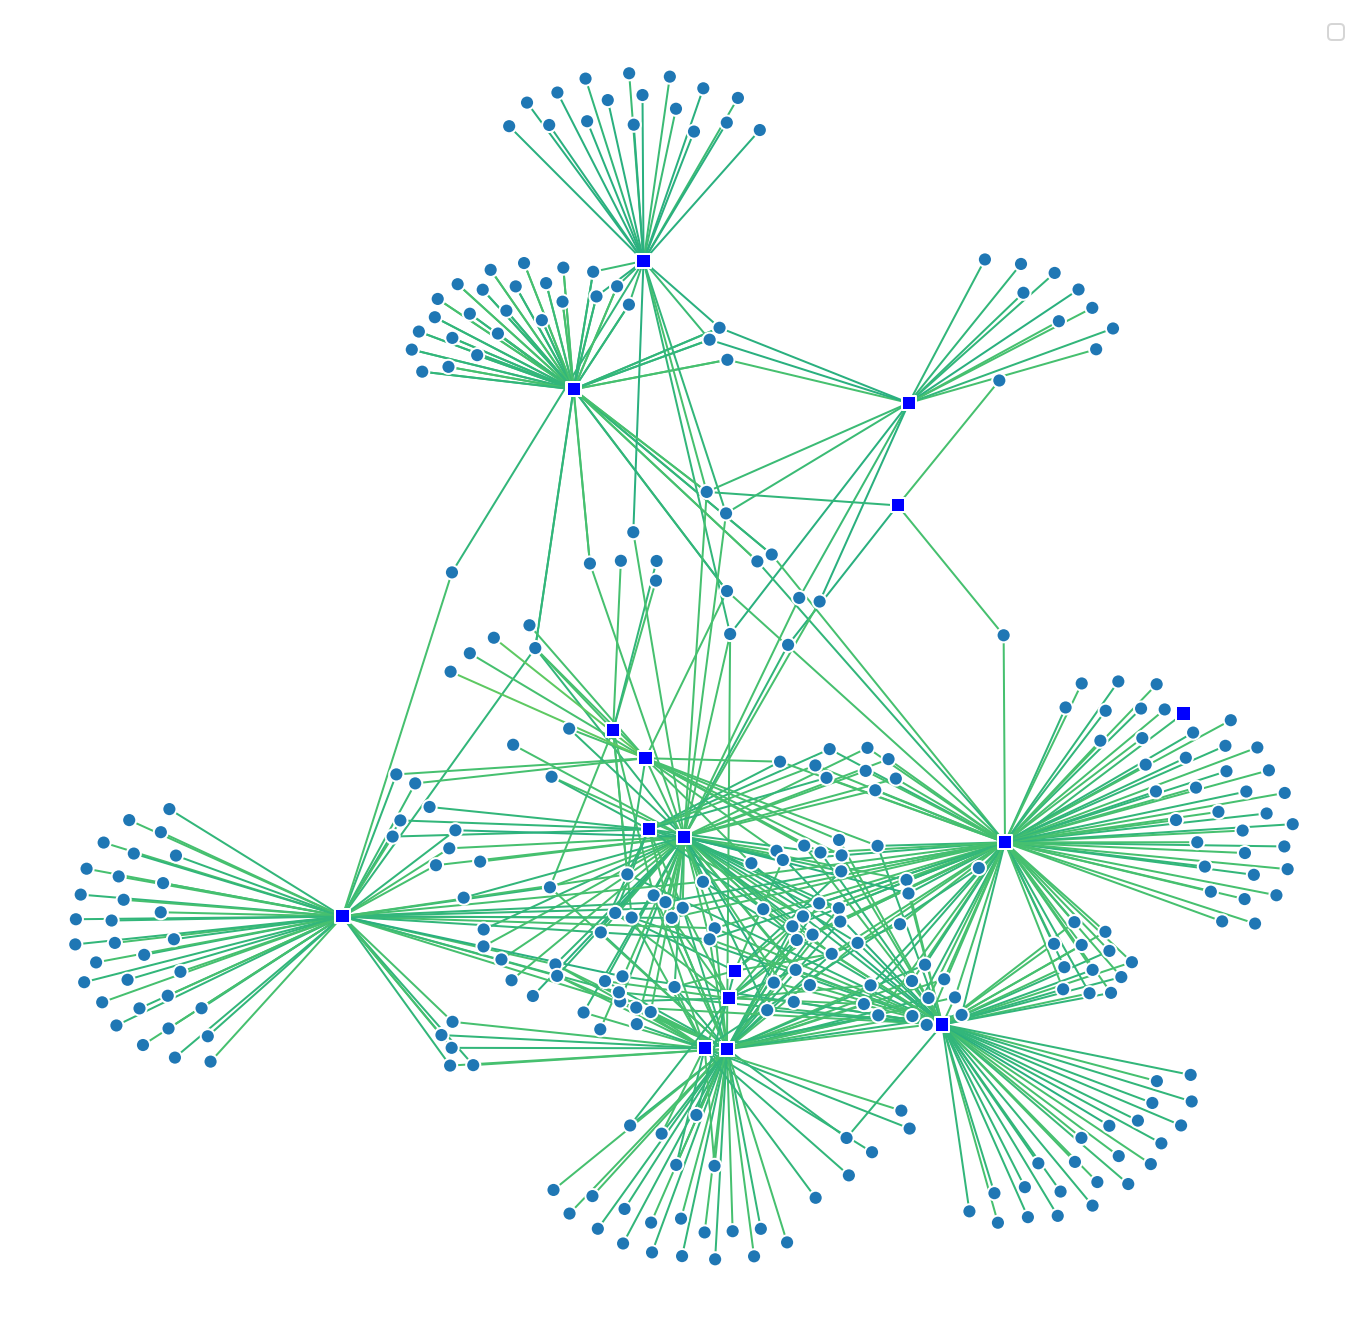

In [43]:
# Code cell for plotting an individual network

from grave import plot_network, use_attributes

colormap = matplotlib.cm.Dark2
n = 2

figure( figsize = ( 12, 12 ) )

#def edge_style(edge_attrs) :
#    alpha = edge_attrs['weight'] / 1000
#    return {'color' : 'black', 'alpha' : alpha }

def edge_style( edge_attributes ) :
    return { 'linewidth' : edge_attributes.get( 'bitscore', 1 ) }

def node_style( node_attributes ) :
    return { 'label' : node_attributes.get( 'label' ) }

g = components[ n ]

centrality = networkx.closeness_centrality( g )
max_centrality = max( centrality.values() )

taxa = set( component_taxa[n].values() )
taxa_colors = { taxon : color for taxon, color in zip( taxa, colormap.colors[:len(taxa)] ) }

for node, node_attributes in g.nodes.data():
    node_attributes['size'] = ( ( max_centrality / centrality[node] ) + .1 ) * 30
    if node_attributes['type'] == 'CRISPR_array' :
        node_attributes['shape'] = 's'
        #node_attributes['color'] = taxa_colors[ component_taxa[n][node] ]
        if node_attributes['source'] == 'isomag' :
            node_attributes['color'] = 'blue'
        else :
            node_attributes['color'] = 'red'
        node_attributes['label'] = component_taxa[n][node]

for u, v, edge_attributes in g.edges.data():
    color_idx = ( 0.75 * edge_attributes['bitscore'] / bit_med )
    cmap = get_cmap()
    edge_attributes['color'] = cmap(color_idx)
    edge_attributes['width'] = 2
    
plt = plot_network( g, layout='spring',
              node_style=use_attributes( [ 'label', 'color', 'shape' ] ),
              edge_style=use_attributes('color') )

legend()

In [49]:
len(components)


1216